In [1]:
import json
import pandas as pd
import gensim
import zipfile
import wget
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('./run_verbs.json', 'r', encoding='UTF-8') as f:
    json_data = json.load(f)

In [3]:
def count_stat(a, count=None):
    if count is None: count = 0
    for key in a:
        if isinstance(a[key], dict):
            count = count_stat(a[key], count)
        else:
            count += a[key]
    return count

In [9]:
json_data.keys()

dict_keys(['идти', 'войти', 'носить', 'выходить', 'лезть', 'выйти', 'бежать', 'вести', 'вылезти', 'тащить', 'носиться', 'лететь', 'гнаться', 'ехать', 'ходить', 'выехать', 'внести', 'вбежать', 'катиться', 'нестись', 'кататься', 'водить', 'ездить', 'бегать', 'входить', 'нести', 'лазить', 'вылететь', 'вылетать', 'въехать', 'блуждать', 'выбежать', 'выбегать', 'бродить', 'плавать', 'гоняться', 'гулять', 'брести', 'гнать', 'летать', 'плыть', 'ползти', 'катить', 'ползать', 'везти', 'влететь', 'втащить', 'таскать', 'выезжать', 'влезать', 'гонять', 'въезжать', 'возить', 'катать', 'вылезать', 'таскаться', 'вносить', 'ввезти', 'влезть', 'влетать', 'ввозить'])

In [4]:
data = json_data['бегать']['на']['Loc']

In [7]:
data_2 = json_data['бежать']['на']['Loc']

In [10]:
data_3 = json_data['нестись']['на']['Loc']

#### Эмбеддинги, использую [туториал](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb)

использую [генсим](https://radimrehurek.com/gensim/models/word2vec.html) 

In [5]:
def get_model_word2vec(model_file):
    with zipfile.ZipFile(model_file, 'r') as archive:
        stream = archive.open('model.bin')
        model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)
    return model    

In [6]:
from gensim.test.utils import get_tmpfile
from gensim.models import FastText

In [7]:
def get_model_fasttext(model_file):
    model = gensim.models.KeyedVectors.load(model_file + "/model.model")
    return model  

In [8]:
models = [
    {
        "model": get_model_word2vec("180.zip"),
        "name": "ruscorpora_upos_cbow_300_20_2019",
        "type": "word2vec"
    },
    {
        "model": get_model_word2vec("220.zip"),
        "name": "ruwikiruscorpora_upos_cbow_300_10_2021",
        "type": "word2vec"
    },
    {
        "model": get_model_fasttext("213"),
        "name": "geowac_lemmas_none_fasttextskipgram_300_5_2020",
        "type": "fasttext"
    },
    {
        "model": get_model_fasttext("214"),
        "name": "geowac_tokens_none_fasttextskipgram_300_5_2020",
        "type": "fasttext"
    },
    {
        "model": get_model_word2vec("185.zip"),
        "name": "tayga_upos_skipgram_300_2_2019",
        "type": "word2vec"
    },
    {
        "model": get_model_fasttext("187"),
        "name": "tayga_none_fasttextcbow_300_10_2019",
        "type": "fasttext"
    }
]

In [9]:
def normalize_word(text):
    return text + "_NOUN"    

In [10]:
def get_embedding(data, model, mode="word2vec"):  
    vectors = list()
    words = list()
    
    #total = count_stat(data)
    
    for i, word in enumerate(data):        
        try:
            if mode == "word2vec":
                v = model[normalize_word(word)]
            elif mode == "fasttext":
                v = model[word]
            #v = v * (data[word] / total)
            vectors.append(v)
            words.append(word)
        except (KeyError, ValueError, AttributeError):
            continue
    
    return vectors, words

In [11]:
len(data)

77

In [12]:
X, words = get_embedding(data, models[0]["model"])

In [13]:
print(len(X), len(words))

74 74


### [Визуализация](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [14]:
from sklearn.manifold import TSNE

In [15]:
def tsne_draw(data):
    plt.figure(figsize=(10,5))
    sns.scatterplot(
        data=data,
        legend="full",
        alpha=1
    )

In [16]:
X_tsne_embedded = TSNE(n_components=2, init='random').fit_transform(X)

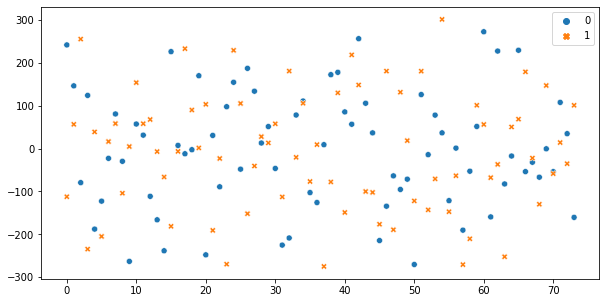

In [17]:
tsne_draw(X_tsne_embedded)

## Кластеризация

In [18]:
def clusters_dict(data, labels):
    new_dict = {}

    for i, word in enumerate(data):
        if labels[i] not in new_dict:
            new_dict[labels[i]] = list()
        new_dict[labels[i]].append(word)
    return new_dict

In [19]:
def print_clusters(data):
    for key in sorted(data):
        res_list = " ".join(data[key])
        print(f"{key}: {res_list}")

In [20]:
def visualization(X, labels, words, embeddings_name, title, old_pal=None):
    
    data = pd.DataFrame(X, columns=['tsne1','tsne2'])
    data['label'] = labels
    data['words'] = words
    
    if old_pal is None:
        pal = sns.color_palette('hls', len(data['label'].unique()))
    else:
        clusters = data['label'].unique()
        pal = dict()
        for i in range(len(old_pal)):
            if i in clusters:
                pal[i] = old_pal[i]
    
    plt.figure(figsize=(14, 7))
    plt.margins(0.1)

    p1 = sns.scatterplot(x='tsne1', # Horizontal axis
                         y='tsne2', # Vertical axis
                         data=data, # Data source
                         hue='label',
                         legend=False,
                         palette=pal)
    
    plt.xlabel(f"Координата x ({embeddings_name})")
    plt.ylabel(f"Координата y ({embeddings_name})")
    plt.title(title)

    for line in range(0, data.shape[0]):
        p1.text(data.tsne1[line] + 0.3, data.tsne2[line] - 0.3, 
                data.words[line], horizontalalignment='left', 
                size='medium', color=pal[data.label[line]], weight='semibold')
        
    return pal

### Кластеризация KMeans

In [21]:
from sklearn.cluster import KMeans

In [22]:
noun = set()
for verb in json_data:
    for adp in json_data[verb]:
        for case in json_data[verb][adp]:
            noun.update(json_data[verb][adp][case])

In [23]:
case_dict = dict()
for verb in json_data:
    for adp in json_data[verb]:
        for case in json_data[verb][adp]:
            if case not in case_dict:
                case_dict[case] = 1
            else:
                case_dict[case] += 1

In [24]:
case_dict

{'Acc': 118, 'Ins': 73, 'Gen': 141, 'Loc': 74, 'Dat': 71}

# Сбор для эксперимента

In [25]:
def check_cluster_dict(cluster_dict, word_1, word_2):
    for key in cluster_dict:    
        if word_1 in cluster_dict[key] and word_2 in cluster_dict[key]:
            return True
    return False

In [26]:
def find_min_clusters(clusters_list, words):
    res_list = list()
    ind_list = list()
    i = 0
    while i < len(words) - 1:
        if i not in ind_list:
            temp_list = list()
            temp_list.append(words[i])
            j = i + 1
            while j < len(words):
                for key in clusters_list[0]:
                    flag = False
                    if words[i] in clusters_list[0][key]:
                        if words[j] in clusters_list[0][key]:
                            count = 1
                            for cluster_ind in range(1, len(clusters_list)):
                                if check_cluster_dict(clusters_list[cluster_ind], words[i], words[j]) is True:
                                    count += 1
                                else:
                                    break
                            if count == len(clusters_list):
                                temp_list.append(words[j])
                                ind_list.append(j)
                                flag = True              
                    if flag is True:
                        break  
                j += 1
            if len(temp_list) > 1:
                res_list.append(temp_list)
        i += 1
    return res_list

In [28]:
def kmeans_experiment(model, data, n_clusters):
    X, words = get_embedding(data, model["model"], model["type"])
    
    X_tsne_embedded = TSNE(n_components=2, init='random').fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X) 
    labels = kmeans.labels_
    
    cluster_dict = clusters_dict(words, labels)
    
    title = f'Проекция кластеризации существительных модели управления "бегать на" (Loc) с помощью KMeans ({n_clusters} кластеров)'
    pal = visualization(X_tsne_embedded, labels, words, model["name"], title)
    
    return cluster_dict

### Способ нахождения минимальных семантических кластеров 

CPU times: user 8.05 s, sys: 5.14 s, total: 13.2 s
Wall time: 4.64 s


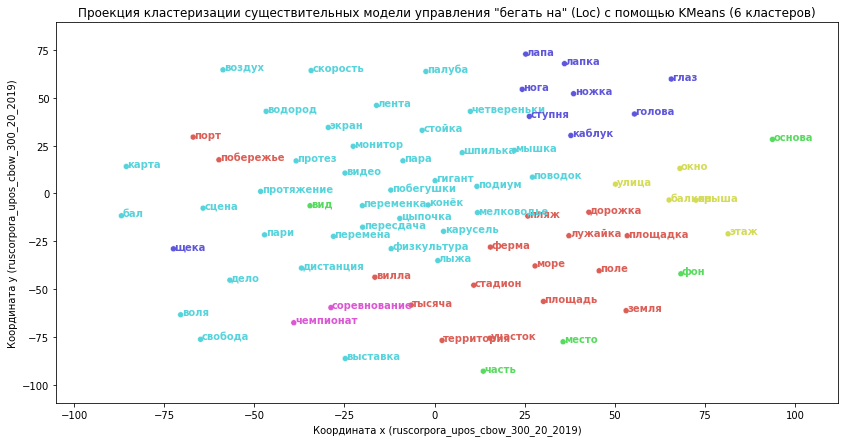

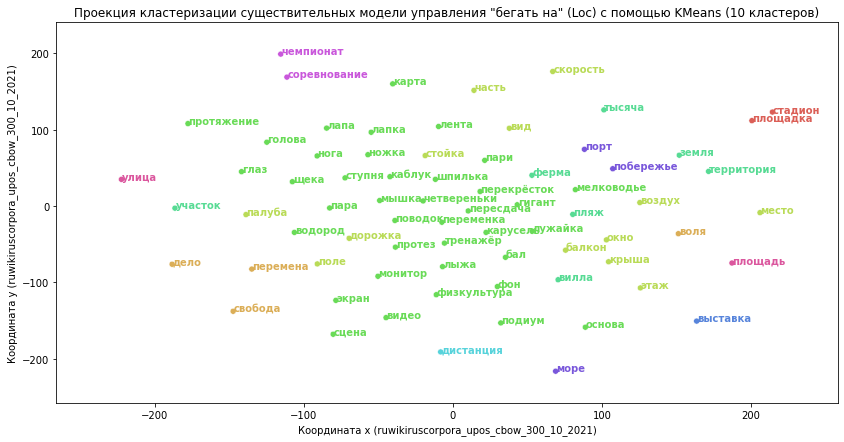

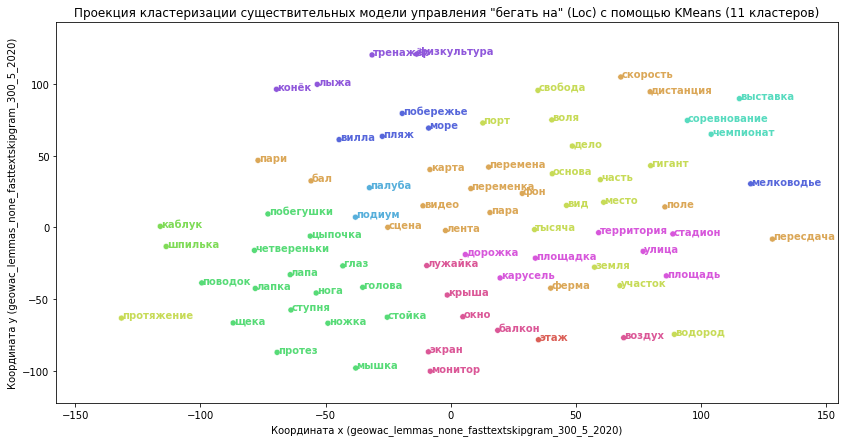

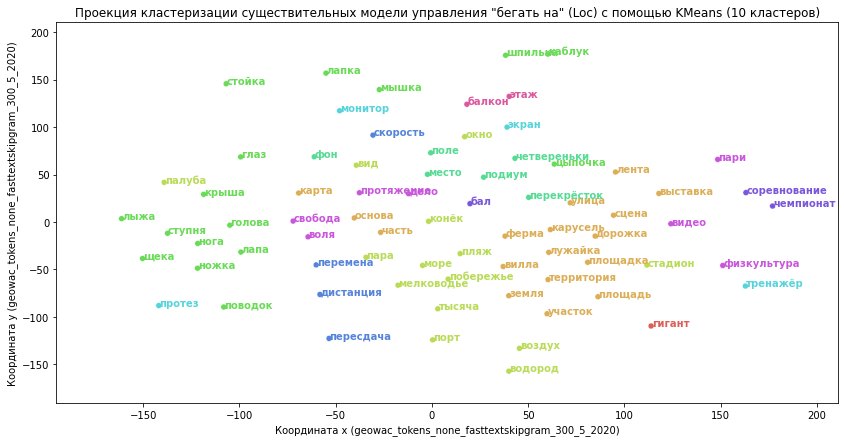

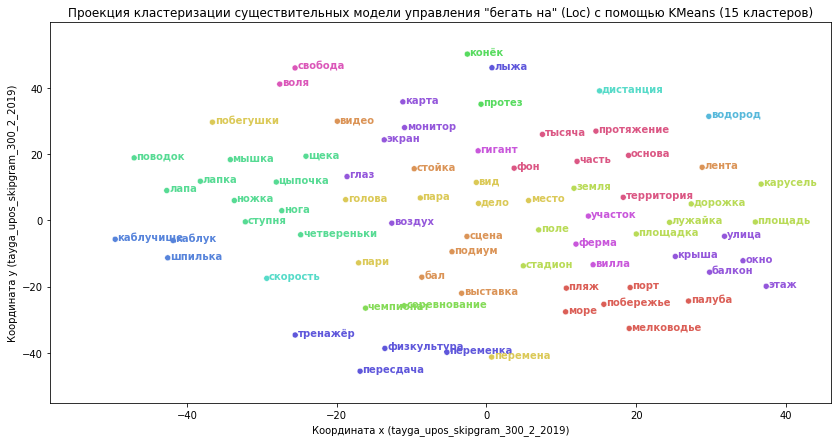

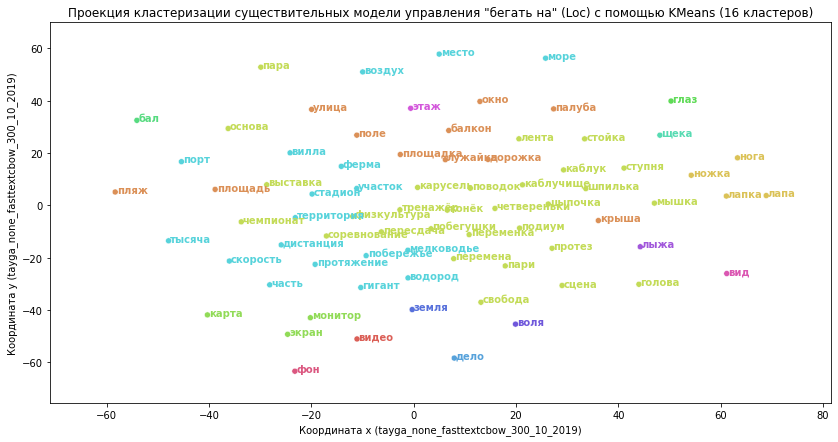

In [36]:
%%time
ap_list = [5, 8, 10, 10, 15, 16]
ap_list = [6, 10, 11, 10, 15, 16]
clusters_list = list()
for i in range(len(models)):
    cluster_dict_temp = kmeans_experiment(models[i], data, ap_list[i])
    clusters_list.append(cluster_dict_temp)

In [37]:
min_clusters = find_min_clusters(clusters_list, list(data))

In [38]:
min_clusters

[['лапка', 'нога', 'ножка', 'лапа'],
 ['море', 'побережье'],
 ['лента', 'сцена'],
 ['экран', 'монитор'],
 ['мышка', 'поводок'],
 ['чемпионат', 'соревнование']]

In [107]:
clusters_list = list()
for i in range(len(models)):
    cluster_dict_temp = kmeans_experiment(models[i], all_data[0], 6)
    clusters_list.append(cluster_dict_temp)

In [108]:
min_clusters = find_min_clusters(clusters_list, list(all_data[0]))

In [109]:
min_clusters

[['голова', 'нога', 'щека', 'ножка', 'лапа'],
 ['свобода', 'пари', 'дело', 'воля', 'пара', 'перемена', 'бал', 'выставка'],
 ['пляж', 'вилла'],
 ['протяжение', 'водород'],
 ['место', 'часть'],
 ['физкультура', 'пересдача'],
 ['ферма', 'земля', 'территория'],
 ['участок', 'поле'],
 ['экран', 'монитор'],
 ['балкон', 'этаж', 'крыша'],
 ['чемпионат', 'соревнование']]

### Как найти подходящее значение n_clusters

In [112]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score

In [161]:
for i in range(len(all_data)):
    print(len(all_data[i]))

77
82
58


In [194]:
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []

X_scaled, words = get_embedding(all_data[2], models[0]["model"], models[0]["type"])

start = 2
end = 15

for i in range(start, end):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    #print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    #print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    #print("-"*100)

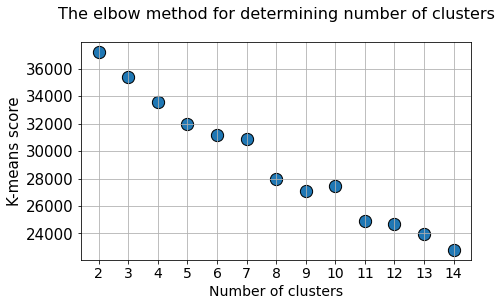

In [195]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(start, end)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(start, end)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

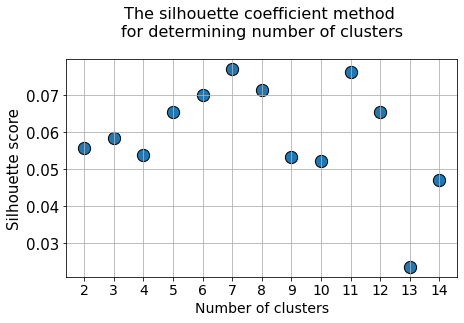

In [196]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(start, end)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(start, end)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

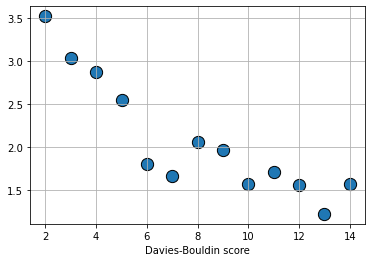

In [197]:
plt.scatter(x=[i for i in range(start, end)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

### AffinityPropagation

In [173]:
from sklearn.cluster import AffinityPropagation

In [180]:
def affinity_propagation_experiment(model, data):
    X, words = get_embedding(data, model["model"], model["type"])
    
    affinity_propagation = AffinityPropagation().fit(X)
    labels = affinity_propagation.labels_  
    
    return len(affinity_propagation.cluster_centers_)

In [189]:
num_clusters_list = list()
for i in range(len(models)):
    cluster_dict_temp = affinity_propagation_experiment(models[i], all_data[2])
    num_clusters_list.append(cluster_dict_temp)

In [190]:
num_clusters_list

[6, 7, 11, 9, 11, 12]

In [41]:
def experiment_kmeans(model, all_data, n_clusters):
    data_fit = all_data[0]
    data_predict_1 = all_data[1]
    data_predict_2 = all_data[2]
    
    X_1, words_1 = get_embedding(data_fit, model["model"], model["type"])
    X_2, words_2 = get_embedding(data_predict_1, model["model"], model["type"])
    X_3, words_3 = get_embedding(data_predict_2, model["model"], model["type"])
    
    X_tsne_embedded_1 = TSNE(n_components=2, init='random').fit_transform(X_1)
    X_tsne_embedded_2 = TSNE(n_components=2, init='random').fit_transform(X_2)
    X_tsne_embedded_3 = TSNE(n_components=2, init='random').fit_transform(X_3)
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='elkan').fit(X_1)
    labels_1 = kmeans.labels_
    
    print("Полученные кластеры (бегать на)")
    cluster_dict_1 = clusters_dict(words_1, labels_1)
    print_clusters(cluster_dict_1)
    
    title = f'Проекция кластеризации существительных модели управления "бегать на" (Loc) с помощью KMeans ({n_clusters} кластеров)'
    pal = visualization(X_tsne_embedded_1, labels_1, words_1, model["name"], title)
    
    labels_2 = kmeans.predict(X_2)
    print("Предсказанные кластеры (бежать на)")
    print_clusters(clusters_dict(words_2, labels_2))
    
    title_2 = f'Проекция кластеризации существительных модели управления "бежать на" (Loc) с помощью KMeans ({n_clusters} кластеров)'
    pal_2 = visualization(X_tsne_embedded_2, labels_2, words_2, model["name"], title_2, pal)
    
    labels_3 = kmeans.predict(X_3)
    print("Предсказанные кластеры (убегать на)")
    print_clusters(clusters_dict(words_3, labels_3))
    
    title_3 = f'Проекция кластеризации существительных модели управления "убегать на" (Loc) с помощью KMeans ({n_clusters} кластеров) (мои примеры)'
    pal_3 = visualization(X_tsne_embedded_3, labels_3, words_3, model["name"], title_3, pal)
    
    return cluster_dict_1

In [42]:
all_data = [data, data_2, data_3]

Полученные кластеры (бегать на)
0: протяжение основа часть
1: улица лужайка пляж ферма площадь палуба балкон дорожка этаж стадион крыша окно поле площадка вилла
2: лыжа цыпочка воздух пари побегушки конёк четвереньки протез скорость пара каблук переменка карусель перемена бал физкультура лента сцена выставка экран стойка карта мышка дистанция монитор видео пересдача фон поводок шпилька подиум
3: тысяча свобода вид море мелководье дело место воля побережье земля участок территория порт водород гигант
4: голова лапка нога глаз щека ступня ножка лапа
5: чемпионат соревнование
Предсказанные кластеры (бежать на)
0: этап протяжение уровень
1: грузовик площадь платформа поле
2: буксир шпилька каблук ранчо интервью цыпочка машина монитор каблучок лезвие катер прямая взгорье колесо скорость яхта экран отрезок лыжа носок кадр остановка перемена фон радость выход четвереньки перекладной телек браузер страница таймер собеседование секция марафон велосипед шар рисунок неделя лекция фотография стоме

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Предсказанные кластеры (убегать на)
0: основание
1: шоссе горка небо грузовик
2: поезд скорость качели пара парус карусель цыпочка ягуар лошадь ход щит машина мотоцикл такси конёк пар велосипед экран ралли гребень поворот колесница конь драндулет шоу санки урок буксир монитор лыжа руль доска шар кадр шип олень сноуборд снимок скак фон
3: лодка предел волна сторона путь дело километр судно
4: спина глаз крыло лапа


/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


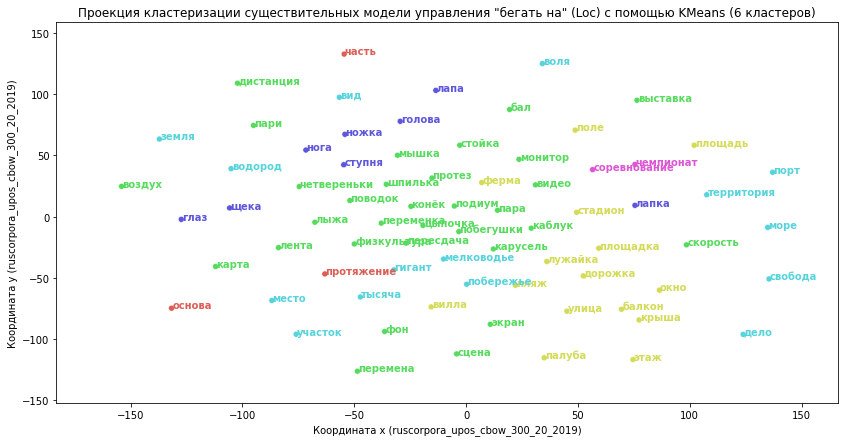

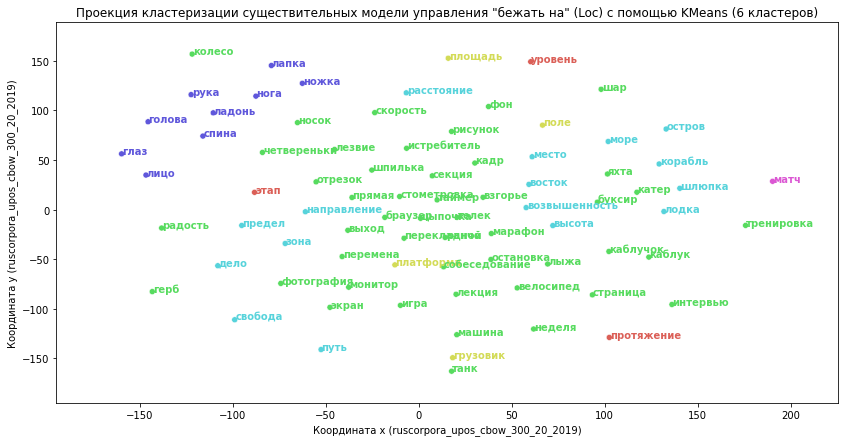

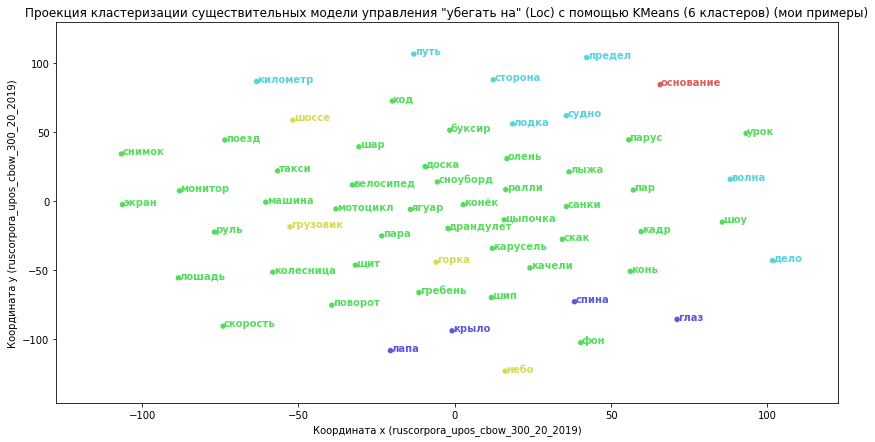

In [43]:
cluster_dict_1 = experiment_kmeans(models[0], all_data, 6)

### AffinityPropagation

In [53]:
from sklearn.cluster import AffinityPropagation

In [54]:
def experiment_affinity_propagation(model, model_name, all_data, mode):
    data_fit = all_data[0]
    data_predict_1 = all_data[1]
    data_predict_2 = all_data[2]
    
    X_1, words_1 = get_embedding(data_fit, model, mode)
    X_2, words_2 = get_embedding(data_predict_1, model, mode)
    X_3, words_3 = get_embedding(data_predict_2, model, mode)
    
    X_tsne_embedded_1 = TSNE(n_components=2, init='random').fit_transform(X_1)
    X_tsne_embedded_2 = TSNE(n_components=2, init='random').fit_transform(X_2)
    X_tsne_embedded_3 = TSNE(n_components=2, init='random').fit_transform(X_3)
    
    affinity_propagation = AffinityPropagation().fit(X_1)
    labels_1 = affinity_propagation.labels_
    
    print("Полученные кластеры (бегать на)")
    print_clusters(clusters_dict(words_1, labels_1))
    
    title = f'Проекция кластеризации существительных модели управления "бегать на" (Loc) с помощью AffinityPropagation'
    kmeans_pal = visualization(X_tsne_embedded_1, labels_1, words_1, model_1_name, title)
    
    labels_2 = affinity_propagation.predict(X_2)
    print("Предсказанные кластеры (бежать на)")
    print_clusters(clusters_dict(words_2, labels_2))
    
    title_2 = f'Проекция кластеризации существительных модели управления "бежать на" (Loc) с помощью AffinityPropagation'
    kmeans_pal_2 = visualization(X_tsne_embedded_2, labels_2, words_2, model_2_name, title_2, kmeans_pal)
    
    labels_3 = affinity_propagation.predict(X_3)
    print("Предсказанные кластеры (убегать на)")
    print_clusters(clusters_dict(words_3, labels_3))
    
    title_3 = f'Проекция кластеризации существительных модели управления "убегать на" (Loc) с помощью AffinityPropagation (мои примеры)'
    kmeans_pal_3 = visualization(X_tsne_embedded_3, labels_3, words_3, model_3_name, title_3, kmeans_pal)

Полученные кластеры (бегать на)
0: лапка нога ножка лапа
1: вид
2: голова воздух каблучище каблук ступня стойка дорожка гигант шпилька подиум
3: глаз
4: дело
5: воля
6: щека
7: лыжа цыпочка пари побегушки конёк четвереньки протез скорость пара переменка карусель перемена лента ферма мышка тренажёр пересдача поводок
8: тысяча пляж море мелководье место побережье земля площадь участок территория порт водород вилла
9: бал
10: улица лужайка сцена палуба балкон крыша окно площадка
11: экран карта монитор видео
12: этаж
13: свобода протяжение физкультура выставка дистанция основа стадион часть чемпионат соревнование
14: поле
15: фон
Предсказанные кластеры (бежать на)
0: рука нога лапка ножка
2: шпилька каблук машина каблучок лезвие колесо ладонь носок голова шар высота спина шлюпка
3: глаз
4: дело
6: лицо
7: буксир цыпочка тренажёр прямая скорость расстояние грузовик отрезок лыжа остановка перемена радость выход четвереньки перекладной телек платформа страница велосипед рисунок неделя фотогр

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Предсказанные кластеры (убегать на)
2: каблук
4: дело
7: пара такси конечность скорость трамвай рисунок минута
8: суша
15: фон


/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


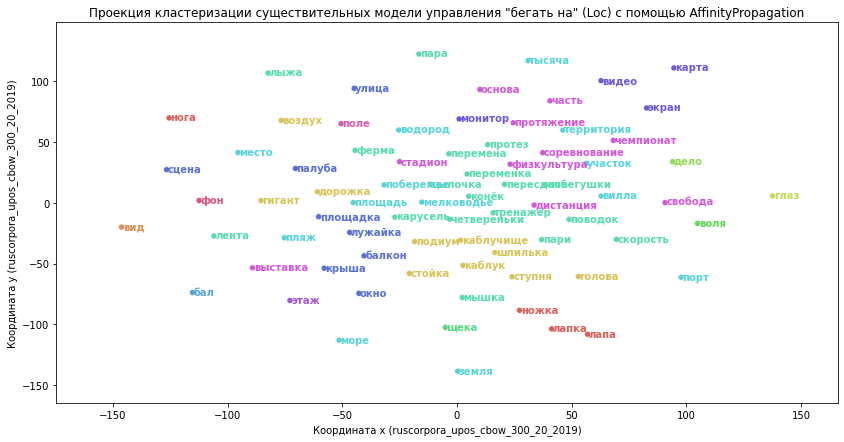

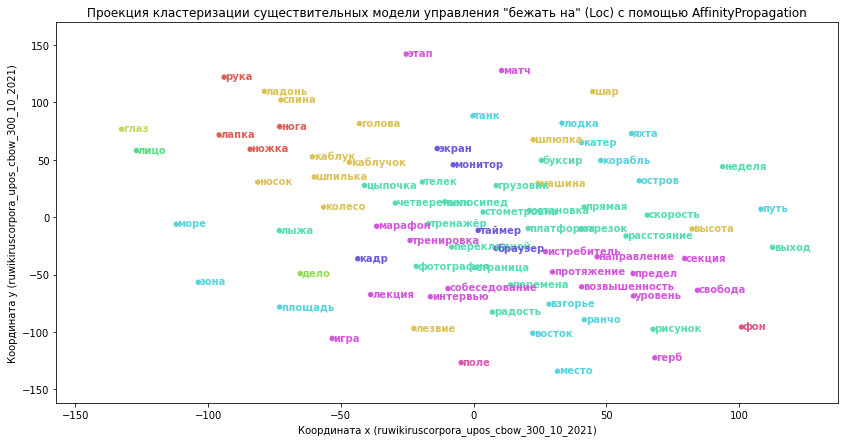

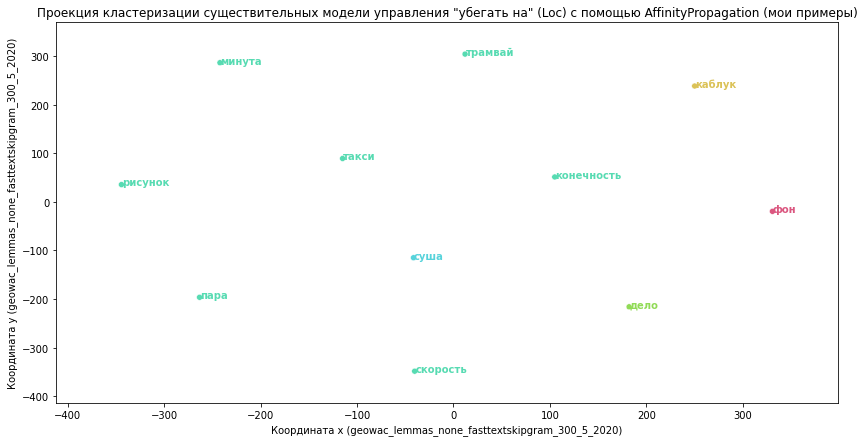

In [57]:
experiment_affinity_propagation(model_6, model_6_name, all_data, "fasttext")

Полученные кластеры (бегать на)
0: лапка нога ножка лапа
1: глаз
2: голова лыжа тысяча свобода цыпочка вид воздух пари побегушки пляж конёк протяжение мелководье четвереньки дело место протез воля скорость пара щека каблук переменка карусель перемена бал физкультура лента ферма ступня земля сцена участок выставка экран стойка палуба карта мышка дистанция дорожка монитор основа стадион часть видео чемпионат водород пересдача соревнование поле гигант фон поводок шпилька подиум
3: море побережье территория порт
4: улица лужайка площадь балкон этаж крыша окно площадка вилла
Предсказанные кластеры (бежать на)
0: рука нога лапка ладонь ножка
1: лицо глаз
2: место буксир шпилька каблук ранчо дело лодка интервью цыпочка машина монитор свобода предел каблучок лезвие катер прямая взгорье колесо скорость расстояние грузовик яхта экран отрезок лыжа носок кадр остановка этап голова перемена фон радость выход четвереньки перекладной телек браузер платформа страница таймер собеседование секция марафо

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Предсказанные кластеры (убегать на)
2: каблук пара такси конечность фон скорость суша дело трамвай рисунок минута


/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


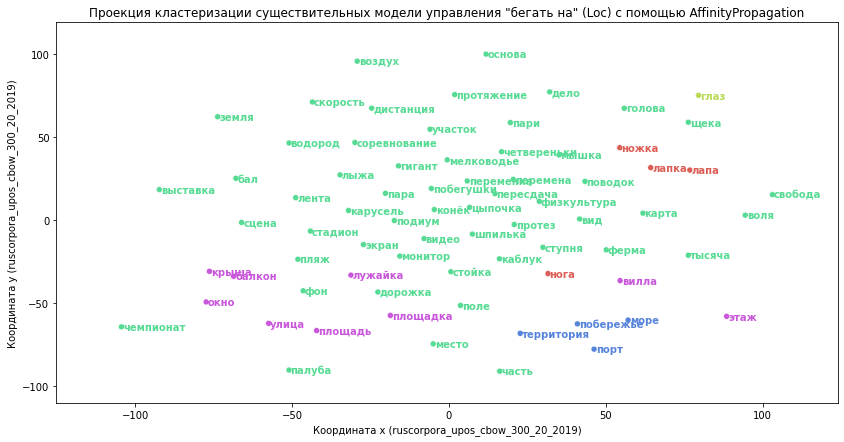

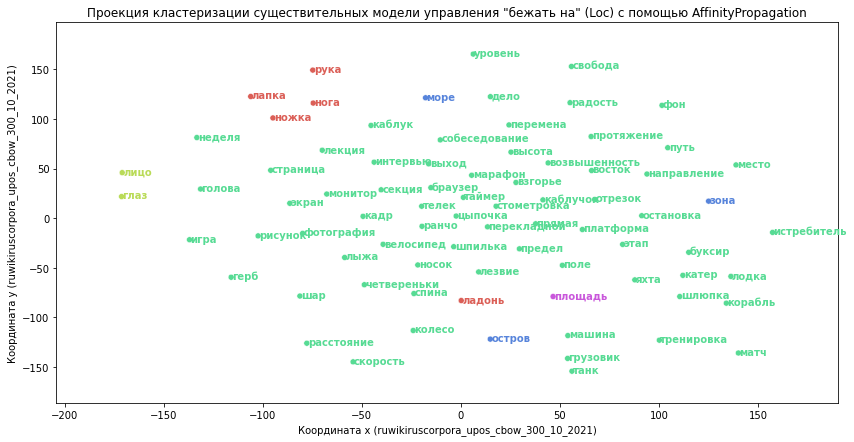

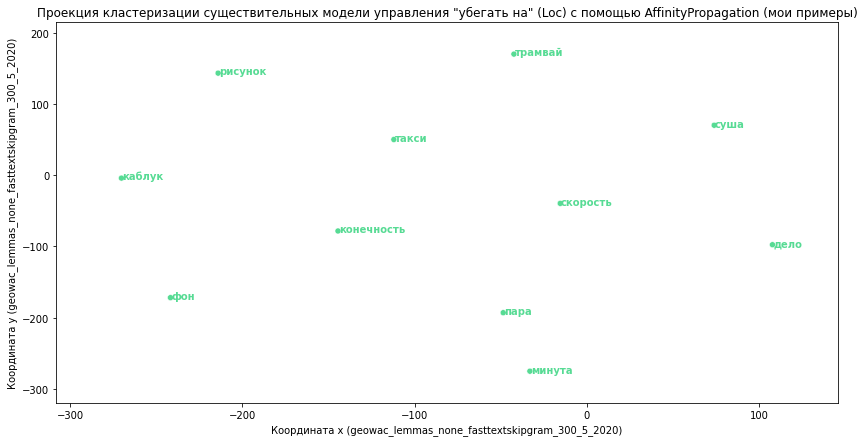

In [58]:
experiment_affinity_propagation(model_1, model_1_name, all_data, "word2vec")

### MiniBatchKMeans

In [47]:
from sklearn.cluster import MiniBatchKMeans

In [48]:
def experiment_mini_batch_kmeans(model, model_name, all_data, mode, n_clusters, batch_size):
    data_fit = all_data[0]
    data_predict_1 = all_data[1]
    data_predict_2 = all_data[2]
    
    X_1, words_1 = get_embedding(data_fit, model, mode)
    X_2, words_2 = get_embedding(data_predict_1, model, mode)
    X_3, words_3 = get_embedding(data_predict_2, model, mode)
    
    X_tsne_embedded_1 = TSNE(n_components=2, init='random').fit_transform(X_1)
    X_tsne_embedded_2 = TSNE(n_components=2, init='random').fit_transform(X_2)
    X_tsne_embedded_3 = TSNE(n_components=2, init='random').fit_transform(X_3)
    
    mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=batch_size).fit(X_1)
    labels_1 = mini_batch_kmeans.labels_
    
    print("Полученные кластеры (бегать на)")
    print_clusters(clusters_dict(words_1, labels_1))
    
    title = f'Проекция кластеризации существительных модели управления "бегать на" (Loc) с помощью MiniBatchKMeans ({n_clusters} кластеров, batch_size={batch_size})'
    kmeans_pal = visualization(X_tsne_embedded_1, labels_1, words_1, model_1_name, title)
    
    labels_2 = mini_batch_kmeans.predict(X_2)
    print("Предсказанные кластеры (бежать на)")
    print_clusters(clusters_dict(words_2, labels_2))
    
    title_2 = f'Проекция кластеризации существительных модели управления "бежать на" (Loc) с помощью MiniBatchKMeans ({n_clusters} кластеров, batch_size={batch_size})'
    kmeans_pal_2 = visualization(X_tsne_embedded_2, labels_2, words_2, model_2_name, title_2, kmeans_pal)
    
    labels_3 = mini_batch_kmeans.predict(X_3)
    print("Предсказанные кластеры (убегать на)")
    print_clusters(clusters_dict(words_3, labels_3))
    
    title_3 = f'Проекция кластеризации существительных модели управления "убегать на" (Loc) с помощью MiniBatchKMeans ({n_clusters} кластеров, batch_size={batch_size}) (мои примеры)'
    kmeans_pal_3 = visualization(X_tsne_embedded_3, labels_3, words_3, model_3_name, title_3, kmeans_pal)

Полученные кластеры (бегать на)
0: лента сцена экран стойка палуба монитор видео фон подиум
1: голова лапка нога глаз четвереньки протез щека каблук ступня ножка мышка лапа поводок шпилька
2: пляж море побережье порт
3: улица воздух балкон этаж крыша окно
4: лыжа тысяча свобода цыпочка вид лужайка пари побегушки конёк протяжение мелководье дело место воля скорость переменка карусель перемена бал физкультура ферма земля площадь участок выставка территория карта дистанция дорожка основа стадион часть чемпионат водород пересдача соревнование поле гигант площадка вилла
5: пара
Предсказанные кластеры (бежать на)
0: монитор экран кадр фон рисунок фотография
1: шпилька каблук рука нога каблучок лезвие лапка колесо ладонь лицо ножка носок голова четвереньки глаз спина
2: остров море яхта
4: место буксир ранчо дело лодка интервью цыпочка машина свобода предел катер прямая взгорье скорость расстояние грузовик отрезок лыжа остановка этап площадь перемена радость выход перекладной телек браузер зо

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


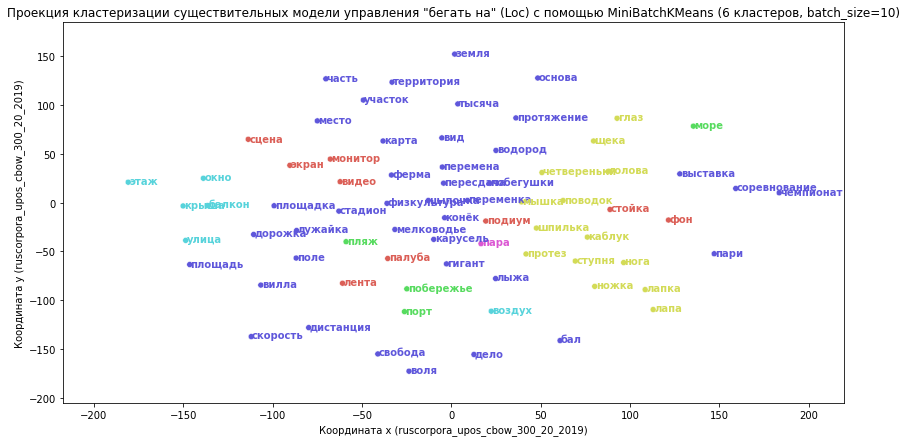

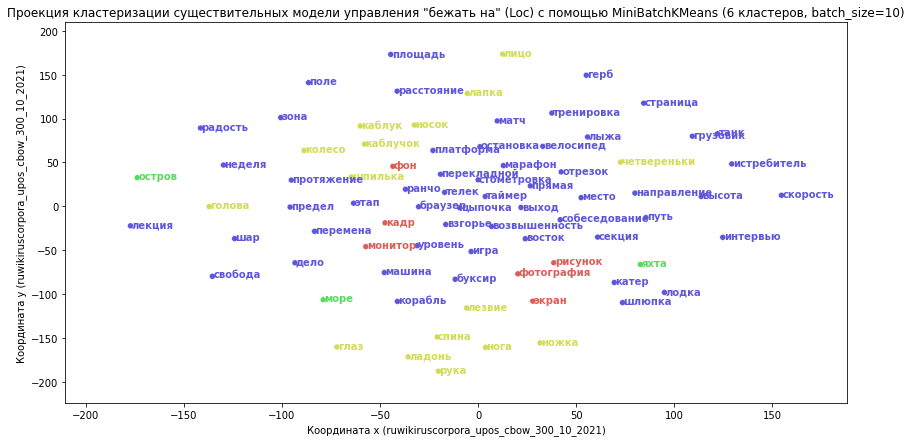

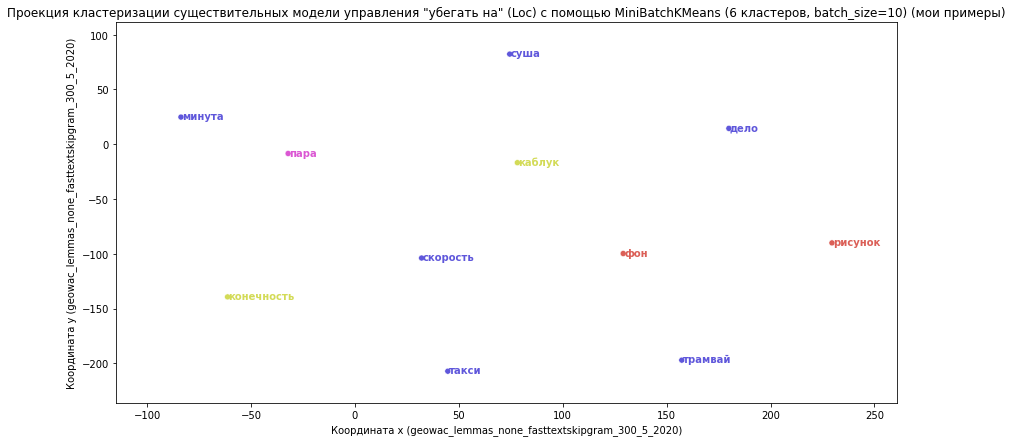

In [51]:
experiment_mini_batch_kmeans(model_1, model_1_name, all_data, "word2vec", 6, 10)

Полученные кластеры (бегать на)
0: лапка нога щека ножка лапа
1: свобода воля
2: воздух море скорость земля водород поле
3: улица лужайка пляж площадь палуба балкон дорожка этаж крыша окно площадка
4: голова цыпочка вид каблучище глаз каблук лента ступня сцена экран стойка мышка монитор видео гигант фон шпилька подиум
5: лыжа тысяча пари побегушки конёк протяжение мелководье четвереньки дело место протез пара переменка карусель перемена побережье бал физкультура ферма участок выставка территория карта порт дистанция основа стадион часть чемпионат тренажёр пересдача соревнование поводок вилла
Предсказанные кластеры (бежать на)
0: рука нога лапка ладонь ножка
1: свобода
2: море скорость высота поле
3: машина площадь
4: шпилька каблук цыпочка монитор каблучок лезвие колесо лицо экран носок кадр голова фон телек шар глаз спина рисунок
5: место буксир остров ранчо дело лодка интервью предел тренажёр катер прямая взгорье расстояние грузовик яхта отрезок лыжа остановка этап перемена радость в

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


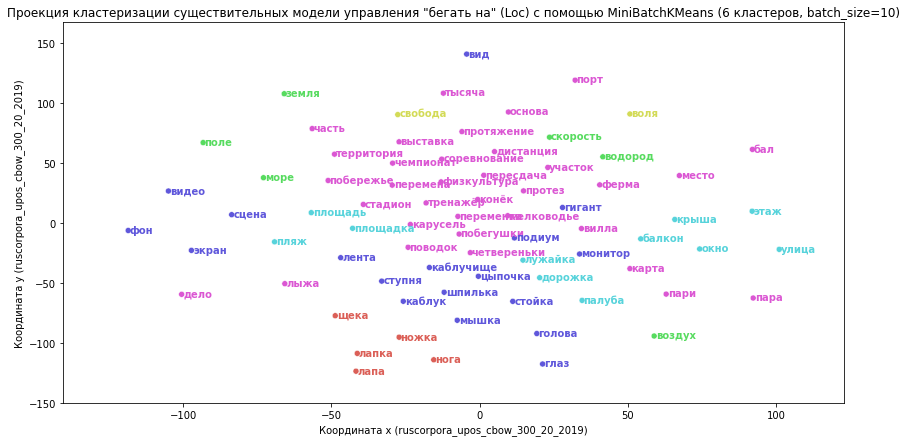

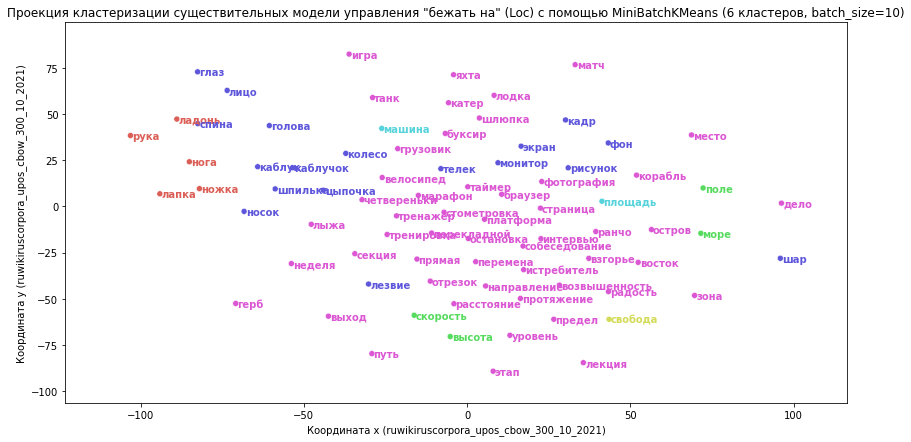

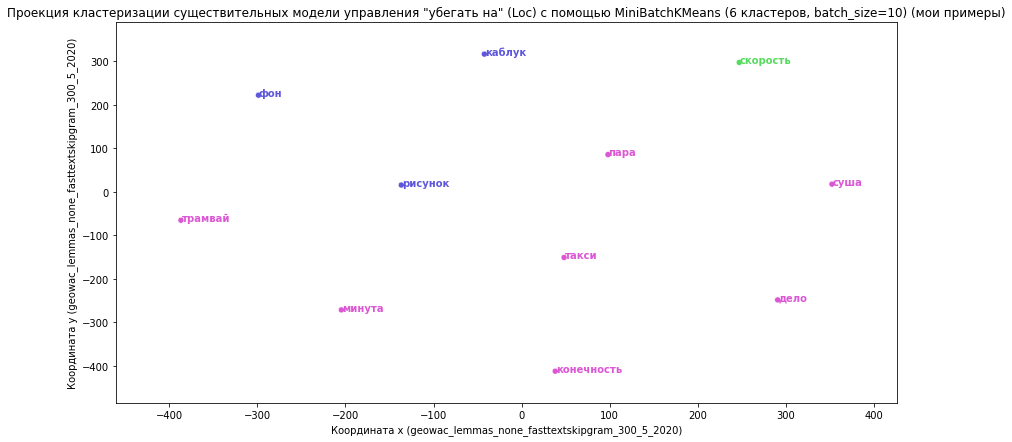

In [52]:
experiment_mini_batch_kmeans(model_6, model_6_name, all_data, "fasttext", 6, 10)

### AgglomerativeClustering

In [59]:
from sklearn.cluster import AgglomerativeClustering

In [61]:
def experiment_agglomerative_clustering(model, model_name, all_data, mode, n_clusters):
    data_fit = all_data[0]
    data_predict_1 = all_data[1]
    data_predict_2 = all_data[2]
    
    X_1, words_1 = get_embedding(data_fit, model, mode)
    X_2, words_2 = get_embedding(data_predict_1, model, mode)
    X_3, words_3 = get_embedding(data_predict_2, model, mode)
    
    X_tsne_embedded_1 = TSNE(n_components=2, init='random').fit_transform(X_1)
    X_tsne_embedded_2 = TSNE(n_components=2, init='random').fit_transform(X_2)
    X_tsne_embedded_3 = TSNE(n_components=2, init='random').fit_transform(X_3)
    
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X_1)
    labels_1 = agglomerative_clustering.labels_
    
    print("Полученные кластеры (бегать на)")
    print_clusters(clusters_dict(words_1, labels_1))
    
    title = f'Проекция кластеризации существительных модели управления "бегать на" (Loc) с помощью AgglomerativeClustering ({n_clusters} кластеров)'
    kmeans_pal = visualization(X_tsne_embedded_1, labels_1, words_1, model_1_name, title)
    
    labels_2 = agglomerative_clustering.fit_predict(X_2)
    print("Предсказанные кластеры (бежать на)")
    print_clusters(clusters_dict(words_2, labels_2))
    
    title_2 = f'Проекция кластеризации существительных модели управления "бежать на" (Loc) с помощью AgglomerativeClustering ({n_clusters} кластеров)'
    kmeans_pal_2 = visualization(X_tsne_embedded_2, labels_2, words_2, model_2_name, title_2, kmeans_pal)
    
    labels_3 = agglomerative_clustering.fit_predict(X_3)
    print("Предсказанные кластеры (убегать на)")
    print_clusters(clusters_dict(words_3, labels_3))
    
    title_3 = f'Проекция кластеризации существительных модели управления "убегать на" (Loc) с помощью AgglomerativeClustering ({n_clusters} кластеров) (мои примеры)'
    kmeans_pal_3 = visualization(X_tsne_embedded_3, labels_3, words_3, model_3_name, title_3, kmeans_pal)

Полученные кластеры (бегать на)
0: тысяча вид воздух море протяжение место скорость побережье земля участок территория порт дистанция основа часть водород поле фон
1: голова лапка нога глаз щека каблук ступня ножка лапа шпилька
2: лыжа цыпочка пари побегушки конёк мелководье четвереньки протез пара переменка карусель бал физкультура лента сцена экран стойка палуба карта мышка монитор стадион видео пересдача гигант поводок подиум
3: улица лужайка пляж ферма площадь балкон дорожка этаж крыша окно площадка вилла
4: выставка чемпионат соревнование
5: свобода дело воля перемена
Предсказанные кластеры (бежать на)
0: буксир лодка машина катер колесо грузовик яхта лыжа велосипед корабль истребитель шлюпка танк
1: шпилька каблук рука нога каблучок лезвие лапка ладонь лицо ножка носок голова четвереньки глаз спина
2: ранчо дело интервью цыпочка свобода прямая взгорье отрезок остановка перемена радость выход перекладной телек браузер платформа страница таймер собеседование секция марафон протяжен

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


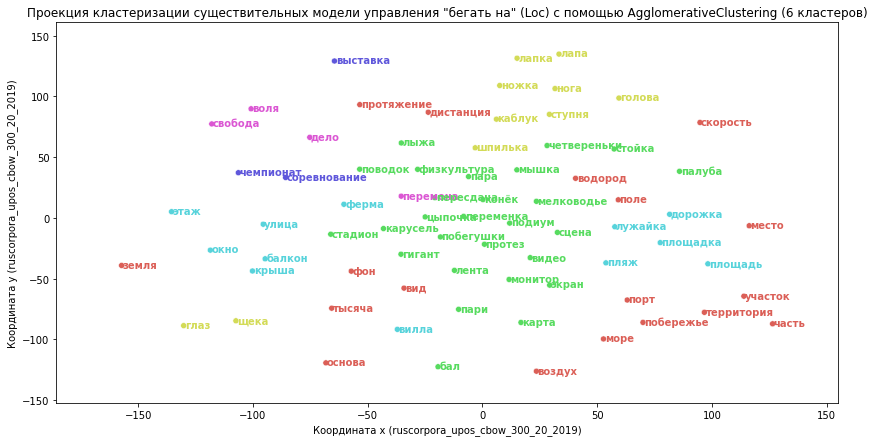

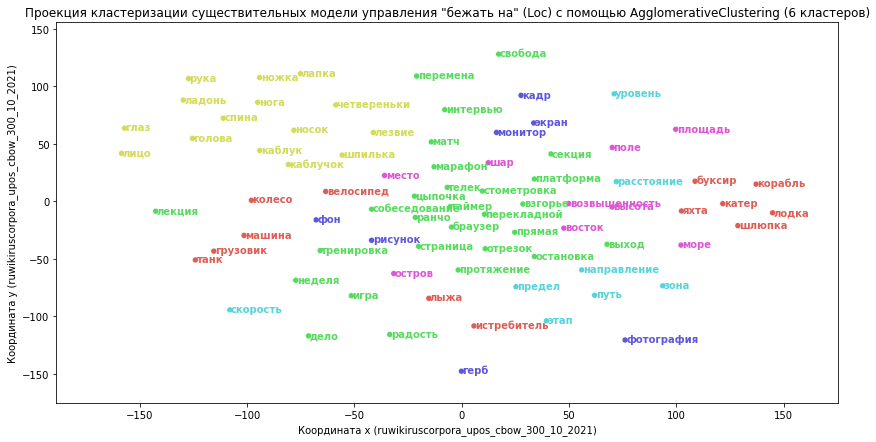

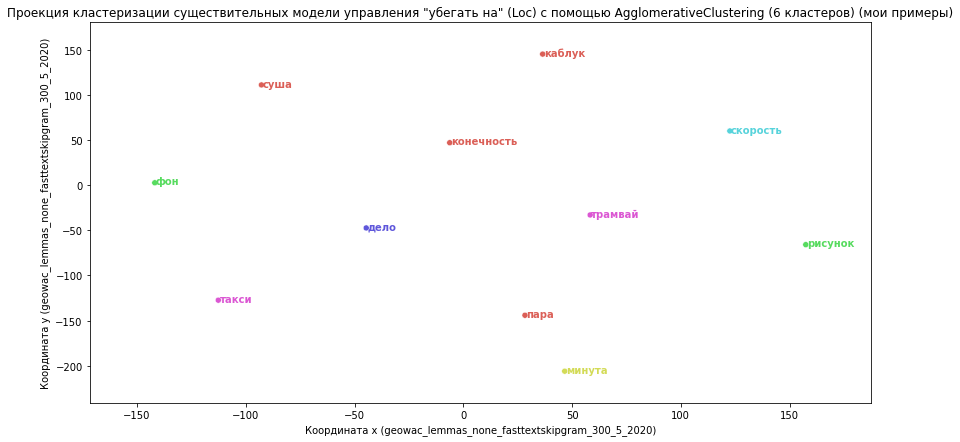

In [62]:
experiment_agglomerative_clustering(model_1, model_1_name, all_data, "word2vec", 6)

Полученные кластеры (бегать на)
0: лыжа тысяча свобода воздух пари побегушки конёк протяжение мелководье четвереньки дело место протез воля скорость пара переменка карусель перемена побережье бал физкультура ферма земля участок выставка территория порт дистанция основа часть чемпионат водород тренажёр пересдача соревнование поле гигант поводок подиум вилла
1: вид лента сцена экран карта монитор видео фон
2: улица лужайка пляж море площадь стойка палуба балкон дорожка стадион крыша окно площадка
3: голова лапка цыпочка каблучище нога щека каблук ступня ножка мышка лапа шпилька
4: глаз
5: этаж
Предсказанные кластеры (бежать на)
0: дело интервью цыпочка монитор тренажёр экран кадр остановка фон выход четвереньки перекладной телек браузер платформа страница таймер секция марафон велосипед рисунок неделя лекция фотография стометровка тренировка игра герб матч
1: место остров ранчо свобода предел лезвие прямая взгорье скорость расстояние отрезок этап площадь перемена радость зона собеседован

/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yudina/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


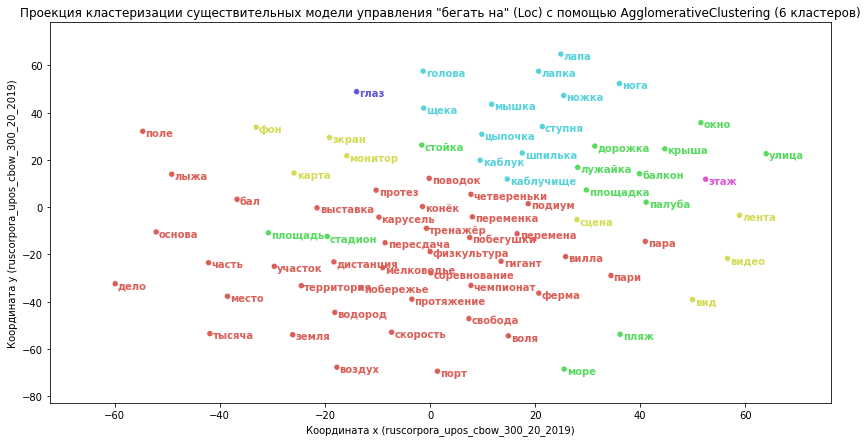

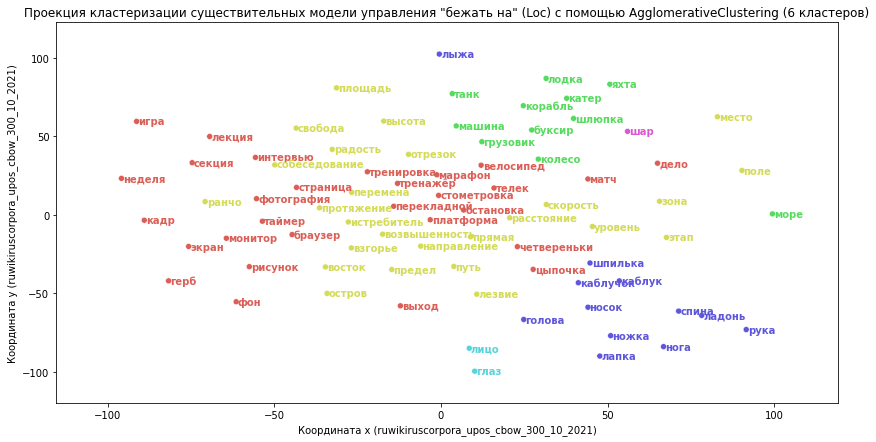

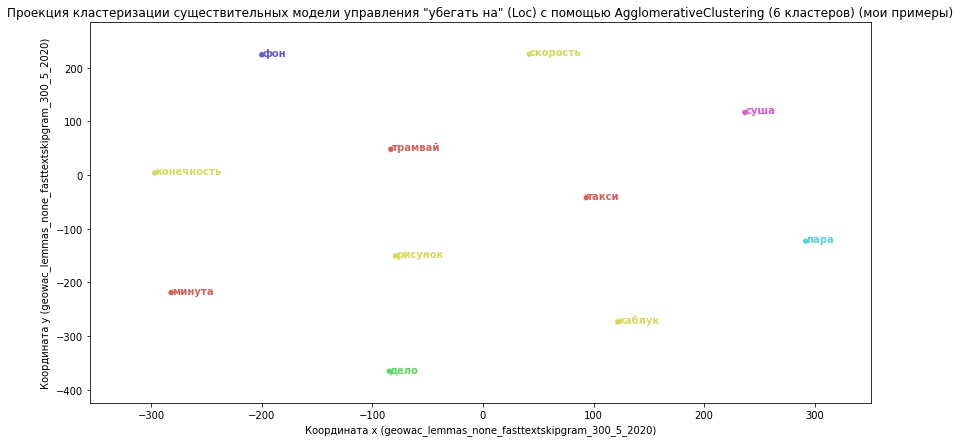

In [64]:
experiment_agglomerative_clustering(model_6, model_6_name, all_data, "fasttext", 6)